In [1]:
%matplotlib inline
import sys
sys.path.append('../../')
from datetime import datetime
from functools import reduce
from os.path import exists
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

# Import User + Movie baseline model
from src.preparation.data import Data
from src.modeling.DampedBaselineModel import DampedBaselineModel
from src.modeling.ALS import ALSRecommender
from math import sqrt

In [2]:
ratings_df = Data.get_rating(filtered=False)

In [3]:
n_splits = 5
max_epochs = 50
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
test_errs = np.zeros((n_splits, max_epochs))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(ratings_df)):
    print("i_fold={}".format(i_fold))
    train_df, test_df = ratings_df.iloc[train_inds], ratings_df.iloc[test_inds]
    baseline_algo = DampedBaselineModel(damping_factor=10)
    rec = ALSRecommender(k=20, baseline_algo=baseline_algo, max_epochs=max_epochs)
    for i_epoch in range(max_epochs):
        rec.fit(train_df, n_epochs=1)
        preds = rec.predict(test_df[['user_id', 'movie_id']])
        test_err = sqrt(mean_squared_error(preds, test_df['rating']))
        # print("[Epoch {}/{}] test MAE: {}".format(i_epoch, max_epochs, test_err))
        test_errs[i_fold, i_epoch] = test_err

print(f"There are {len(rec.user_map)} users and {len(rec.item_map)} items")

i_fold=0
i_fold=1
i_fold=2
i_fold=3
i_fold=4
There are 943 users and 1651 items


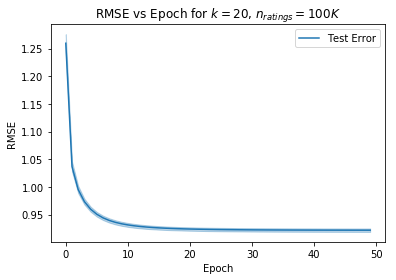

In [4]:
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.plot(np.arange(max_epochs), test_avg, label='Test Error')
plt.fill_between(np.arange(max_epochs), test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title(r'RMSE vs Epoch for $k=20$, $n_{ratings}=100K$')
plt.show()

In [7]:
n_splits = 5
max_epochs = 15
kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)
k_list = [1, 2, 5, 10, 20, 50, 100]
small_df = ratings_df.iloc[:100000]
train_errs = np.zeros((n_splits, len(k_list)))
test_errs = np.zeros((n_splits, len(k_list)))
for i_fold, (train_inds, test_inds) in enumerate(kf.split(small_df)):
    print("i_fold={}: ".format(i_fold), end='')
    train_df, test_df = small_df.iloc[train_inds], small_df.iloc[test_inds]
    baseline_algo = DampedBaselineModel(damping_factor=10)
    for i_k, k in enumerate(k_list):
        print("k={}, ".format(k), end='')
        rec = ALSRecommender(k=k, baseline_algo=baseline_algo, max_epochs=max_epochs)
        rec.fit(train_df)
        preds = rec.predict(test_df[['user_id', 'movie_id']])
        test_err = sqrt(mean_squared_error(preds, test_df['rating']))
        test_errs[i_fold, i_k] = test_err
    print()

i_fold=0: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=1: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=2: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=3: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 
i_fold=4: k=1, k=2, k=5, k=10, k=20, k=50, k=100, 


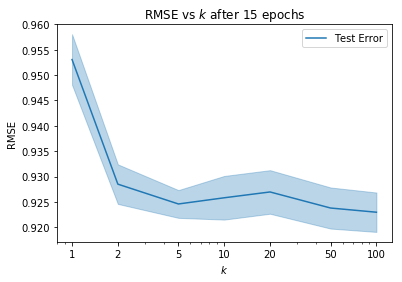

In [8]:
test_avg, test_std = test_errs.mean(axis=0), test_errs.std(axis=0)
l, = plt.semilogx(k_list, test_avg, label='Test Error')
plt.fill_between(k_list, test_avg-test_std, test_avg+test_std,
                 color=l.get_color(), alpha=0.3)
plt.xticks(k_list, k_list)
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel('RMSE')
plt.title(r'RMSE vs $k$ after {} epochs'.format(max_epochs))
plt.show()